<a href="https://colab.research.google.com/github/MathHenrique065/CIFAR-10_VGG19_basic_model/blob/main/DIO_Transfer_Learning_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Project

# Dataset: Detecting Alzheimer's and Parkinson Disease

In [107]:
%matplotlib inline
import numpy as np
import keras
import tensorflow.keras as tf
import pandas as pd

import os
import zipfile
import shutil
import random
#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"




from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation,   GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.models import Model

## Extracting the Dataset

In [108]:
!pip install opendatasets

In [109]:
import opendatasets as od

In [110]:
od.download("https://www.kaggle.com/datasets/farjanakabirsamanta/alzheimer-diseases-3-class")

Skipping, found downloaded files in "./alzheimer-diseases-3-class" (use force=True to force download)


## Separating in Folders

In [111]:

# Caminho para o diretório baixado
downloaded_folder_path = '/content/alzheimer-diseases-3-class'

# Caminho para o diretório de saída para o pré-processamento
output_folder_path = '/content/preprocessed_data'

# Defina class labels
class_labels = ['CONTROL', 'AD', 'PD']

# Crie pastas de saída para conjuntos de treinamento, validação e teste
for label in class_labels:
    os.makedirs(os.path.join(output_folder_path, 'train', label), exist_ok=True)
    os.makedirs(os.path.join(output_folder_path, 'val', label), exist_ok=True)
    os.makedirs(os.path.join(output_folder_path, 'test', label), exist_ok=True)

# Divida os dados em conjuntos de treinamento, validação e teste
for label in class_labels:
    image_folder = os.path.join(downloaded_folder_path, '3_cls/train', label)
    images = os.listdir(image_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)

    # Copie as imagens para as pastas correspondentes
    for image in train_images:
        shutil.copy(os.path.join(image_folder, image), os.path.join(output_folder_path, 'train', label))
    for image in val_images:
        shutil.copy(os.path.join(image_folder, image), os.path.join(output_folder_path, 'val', label))
    for image in test_images:
        shutil.copy(os.path.join(image_folder, image), os.path.join(output_folder_path, 'test', label))



## Data Generators

In [142]:
# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [143]:

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_folder_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_folder_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4143 images belonging to 3 classes.
Found 1037 images belonging to 3 classes.


In [144]:

# Split a portion of the training data for testing
train_images, test_images, train_labels, test_labels = train_test_split(
    train_generator.filepaths,
    train_generator.labels,
    test_size=0.2,
    random_state=42
)

In [145]:

# Convert numerical labels to string labels
train_labels_str = [str(label) for label in train_labels]
test_labels_str = [str(label) for label in test_labels]

In [146]:

# Set up a separate data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_images, 'class': test_labels_str}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 829 validated image filenames belonging to 3 classes.


In [147]:
# Separando em inputs (x) e labels (y)
train_x, train_y = next(train_generator)
val_x, val_y = next(val_generator)

test_x, test_y = next(test_generator)

# Training the model

### Training a customized CNN model



In [170]:

# Define EfficientNet model using TensorFlow and Keras

base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

model = Sequential([
    base_model,

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(3, activation='softmax')
])

In [171]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_10 (Rescaling)    (None, 224, 224, 3)          0         ['input_15[0][0]']            
                                                                                                  
 normalization_5 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_10[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_11 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_5

In [175]:
print("Input dimensions: ", train_x.shape[1:])

Input dimensions:  (224, 224, 3)


In [176]:
# build the network
print("Input dimensions: ", train_x.shape[1:])


model = Sequential([


        Conv2D(32, (3, 3), input_shape=train_x.shape[1:]),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(32, (3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),



        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(3, activation='softmax'),


])


model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_16 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_26 (Dropout

### Métricas

In [82]:
from tensorflow.keras import metrics

In [83]:
from tensorflow_addons.metrics import F1Score

In [152]:
metrics_model =   ['accuracy',
                    metrics.Precision(name='precision'),
                    metrics.Recall(name='recall'),
                    metrics.AUC(name='auc'),
                    F1Score(num_classes=3, name='f1_score')]

### Compilando o Modelo

In [177]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
# You can then compile and train the model using the generated data generators
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=metrics_model
              )

In [178]:

# model.fit(, epochs=epochs, validation_data=val_generator)



history = model.fit(train_x, train_y, batch_size=16, epochs=50, validation_data=(val_x, val_y))



Epoch 1/50
2/2 [==============================] - 7s 742ms/step - loss: 1.1196 - accuracy: 0.4062 - precision: 0.4375 - recall: 0.2188 - auc: 0.6047 - f1_score: 0.1926 - val_loss: 0.8549 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 1.0000 - val_f1_score: 0.3333
Epoch 2/50
2/2 [==============================] - 0s 146ms/step - loss: 1.0083 - accuracy: 0.5000 - precision: 0.5455 - recall: 0.3750 - auc: 0.6826 - f1_score: 0.3497 - val_loss: 0.7397 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 1.0000 - val_f1_score: 0.3333
Epoch 3/50
2/2 [==============================] - 0s 145ms/step - loss: 0.9424 - accuracy: 0.5000 - precision: 0.6667 - recall: 0.3125 - auc: 0.7231 - f1_score: 0.3609 - val_loss: 0.9974 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 148ms/step - loss: 1.0341 -

Let's plot the validation loss and validation accuracy over time.

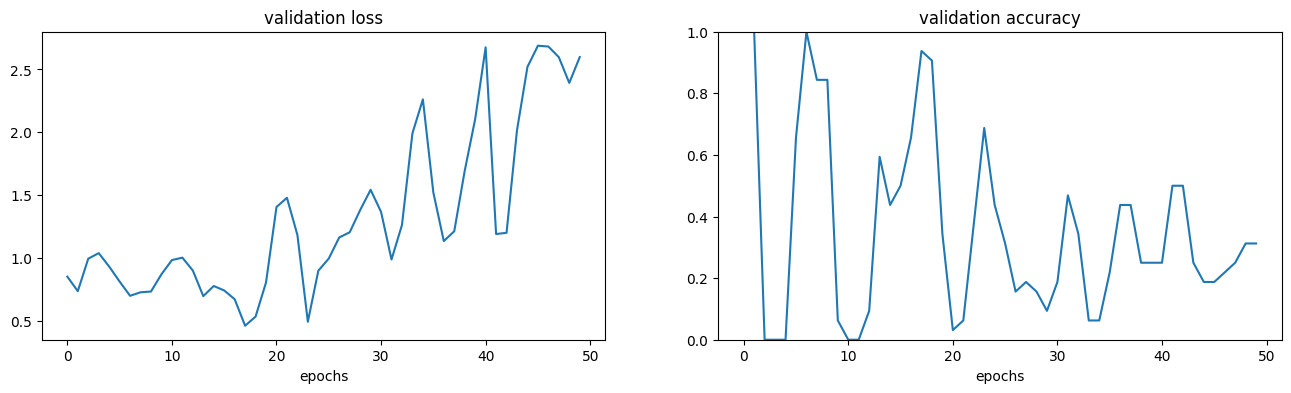

In [179]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Notice that the validation loss begins to actually rise after around 16 epochs, even though validation accuracy remains roughly between 40% and 50%. This suggests our model begins overfitting around then, and best performance would have been achieved if we had stopped early around then. Nevertheless, our accuracy would not have likely been above 50%, and probably lower down.

We can also get a final evaluation by running our model on the training set. Doing so, we get the following results:

In [182]:
result = model.evaluate(test_x, test_y, verbose=0)
print('Test result:', result)

Test result: [1.9329472780227661, 0.53125, 0.53125, 0.53125, 0.75927734375, array([0.4347826 , 0.57142854, 0.6666667 ], dtype=float32)]


In [183]:
print('Test loss:', result[0])
print('Test accuracy:', result[1])  # Assuming accuracy is the second metric

Test loss: 1.9329472780227661
Test accuracy: 0.53125


## Transfer Learning - ViT

In [184]:
pip install -U tensorflow-addons

In [185]:
import tensorflow_addons as tfa

In [186]:
!pip install --quiet vit-keras

from vit_keras import vit, visualize
import tensorflow_addons as tfa

In [194]:
#vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
#vgg.summary()


ViT_model = vit.vit_b16(  #vit.vit_b16
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 3)

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[16,16,3,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2] name: 

In [ ]:
ViT_model.summary()

In [ ]:
model = keras.Sequential([
    ViT_model,  # Include the ViT model as the base
    keras.layers.Flatten(),  # Flatten the output of ViT
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(3, activation='softmax')  # Output layer with 3 classes
])

In [140]:
ViT_model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=metrics_model)

In [141]:
history2 = ViT_model.fit(train_x, train_y,
                         batch_size=16,
                         epochs=30,
                         validation_data=(val_x, val_y))

Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node vit-l16/Transformer/encoderblock_1/MlpBlock_3/lambda/Gelu/truediv defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-141-97b375df5920>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/vit_keras/layers.py", line 173, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/vit_keras/layers.py", line 147, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 348, in gelu

failed to allocate memory
	 [[{{node vit-l16/Transformer/encoderblock_1/MlpBlock_3/lambda/Gelu/truediv}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_401275]

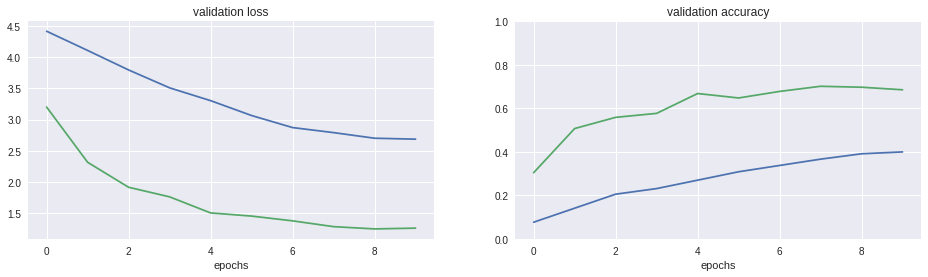

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [105]:
result = ViT_model.evaluate(test_x, test_y, verbose=0)
print('Test result:', result)

Test result: [1.137289047241211, 0.46875]


In [ ]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])


0.6425913


### Transfer Learning - Mamba Network (Work in Progress)